In [1]:
import os
import sys
import pandas as pd
import numpy as np
import regex as re
import mygene
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, fminbound
from scipy import stats
from tableanalyser import *

In [2]:
mg = mygene.MyGeneInfo()

In [3]:
#mg.getgene("ENSG00000221782", 'name,symbol,refseq.rna,type_of_gene,exac.bp')

In [4]:
working_dir = "/Users/filippo/Developer/tesi"
os.chdir(working_dir)
dirs = os.listdir("data")

In [5]:
len(dirs)

4497

In [6]:
normalisation_str = "counts"

In [7]:
df = pd.read_csv(("%s/mainTable.csv"%working_dir), index_col=[0])
#df = df.to_sparse(fill_value=0.)
df.head()

,ab30d37c-c510-496f-a704-6687ea39b847.htseq.counts.gz,e89c96d6-a2ab-4bac-bbba-8c52d49a3edf.htseq.counts.gz,d2587070-cb7d-440d-ae49-52f5077248e6.htseq.counts.gz,e733093b-8a60-46d7-9ddd-ec8a82206126.htseq.counts.gz,f02be12f-2e34-4089-be5c-0f81ca6038c8.htseq.counts.gz,6b424e38-1004-4434-be48-ee01dad67982.htseq.counts.gz,6f8c77f2-67de-411d-a03d-5fef3216b71b.htseq.counts.gz,3490b791-16ec-41e8-9015-5f3d33c856c0.htseq.counts.gz,97675f21-ce94-4e7c-bc46-179cc2903bf3.htseq.counts.gz,df692bf8-d523-4528-aa0c-a0549373adee.htseq.counts.gz,...,87968a34-cdba-4335-92d9-0f5b34ed27c9.htseq.counts.gz,32f7779d-9065-4241-ad44-efe90148ac23.htseq.counts.gz,358f2893-02b2-4d36-9c76-b818c28b6027.htseq.counts.gz,11797830-6218-43c6-8c41-515583575668.htseq.counts.gz,8677d42c-aef1-444d-b9a2-0dbcced0e886.htseq.counts.gz,fbef38b2-454d-44e6-b27f-5a790c6f8c17.htseq.counts.gz,c327832d-9cf8-4734-a745-42879ebe6702.htseq_counts.txt.gz,90d19c5c-f80b-454b-b776-99d13f01617e.htseq.counts,6d9c73d6-215a-49f9-bc9f-af019f8db55c.htseq.counts.gz,9c9ee7b5-0227-43c2-be55-909751dbd61a.htseq.counts.gz
ENSG00000167578,475,494,1008,265,325,278,582,613,357,361,...,901,269,458,1395,621,384,403,697,369,392
ENSG00000078237,409,475,1082,660,804,535,1215,1226,751,675,...,485,651,154,812,674,73,395,598,1240,1090
ENSG00000146083,3211,4264,5319,3457,3864,1257,3702,3043,4536,3259,...,2849,2141,1071,2456,4049,1466,1933,2840,2657,5324
ENSG00000158486,53,18,168,12,116,62,97,18,90,836,...,425,198,0,27,25,790,28,4,153,318
ENSG00000198242,11411,20733,15310,32889,11328,27760,15145,25741,18640,27510,...,8388,14479,12937,24780,27905,15907,4641,24878,11621,39908


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19369 entries, ENSG00000167578 to ENSG00000181518
Columns: 3634 entries, ab30d37c-c510-496f-a704-6687ea39b847.htseq.counts.gz to 9c9ee7b5-0227-43c2-be55-909751dbd61a.htseq.counts.gz
dtypes: int64(3634)
memory usage: 537.2+ MB


In [9]:
ngenes = len(df.index)
nfiles = len(df.columns)
print("genes:%d\trealizations:%d"%(ngenes,nfiles))

genes:19369	realizations:3634


## Means sigmas

In [10]:
df_mv = pd.read_csv("meanVariances.csv", index_col = [0])
#type_of_gene='protein-coding'
#df_mv = df_mv.loc[df_mv['type_of_gene']==type_of_gene]
df_mv_occ=pd.read_csv("O.dat", header=None)
#df_mv.drop("type_of_gene", axis=1, inplace=True)
df_mv.insert(3, 'occurrence', df_mv_occ.values)
#df_mv.insert(2,'type_of_gene','protein-coding')
df_mv.head()

,mean,variance,type_of_gene,occurrence
ENSG00000167578,788.433,285765.0,,1.00000
ENSG00000078237,717.648,341307.0,,1.00000
ENSG00000146083,3921.110,8143170.0,,1.00000
ENSG00000158486,112.376,106166.0,,0.97716
ENSG00000198242,28493.700,631118000.0,,1.00000


In [11]:
#df_mv.round(2).to_csv("meanVariances.csv",index=True,header=True)

In [12]:
df_mv.fillna(value=0.,inplace=True)

In [13]:
means = df_mv['mean'].values
variances = df_mv['variance'].values
occurrences = np.array(df_mv['occurrence'].values*nfiles, dtype=int)
len(df_mv)

19369

### plot

#### **var** versus **mean**

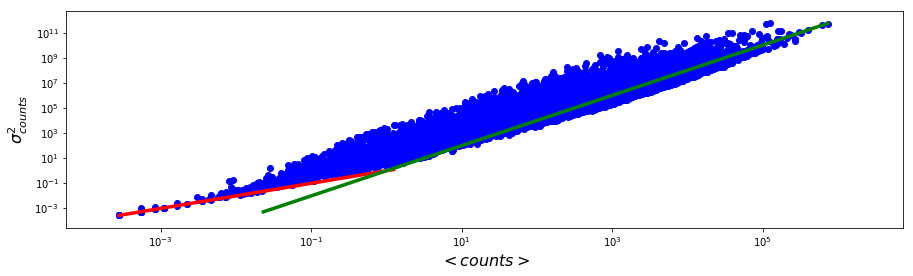

In [14]:
x_lin = np.logspace(np.log10(means[means.nonzero()].min()),np.log10(means[means.nonzero()].max()), dtype=float,num=50)
fig=plt.figure(figsize=(15,4))
plt.scatter(means, variances, c='b')
plt.plot(x_lin[:20],x_lin[:20], 'r-', lw=3.5, label='$<%s>$'%normalisation_str)
plt.plot(x_lin[-40:],np.power(x_lin[-40:],2), 'g-', lw=3.5, label='$<%s>^2$'%normalisation_str)

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((variances[variances.nonzero()].min()/10,np.power(10,np.log10(variances.max())+1)))
plt.show()
fig.savefig("varmean_loglog.png")

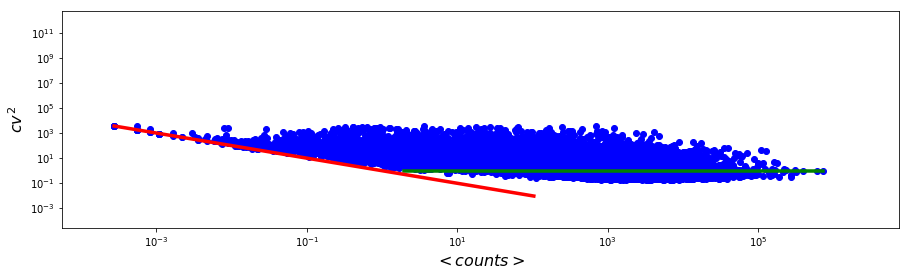

In [15]:
cv2 = [variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0]
fig=plt.figure(figsize=(15,4))
plt.scatter(means[means.nonzero()], cv2, c='b')
plt.plot(x_lin[-30:],[1 for _ in x_lin[-30:]], 'g-', lw=3.5, label='$<%s>$'%normalisation_str)
plt.plot(x_lin[:30],1./x_lin[:30], 'r-', lw=3.5, label='$<%s>^2$'%normalisation_str)

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((variances[variances.nonzero()].min()/10,np.power(10,np.log10(variances.max())+1)))
plt.show()
fig.savefig("cvmean_loglog.png")

### mean versus occurrence

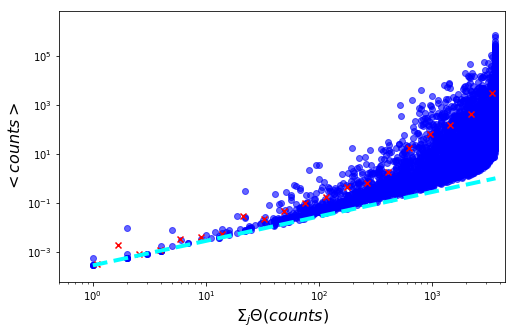

In [18]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences, means, c='b', alpha=0.6, label='data')
if 'counts' in normalisation_str:
    plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles), lw=4, label='', c='cyan', ls='--')
bin_means, bin_edges, _ = stats.binned_statistic(occurrences, means, statistic='mean', bins=np.logspace(-3,6))
x = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(x,bin_means, marker='x', c='r')
plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.show()
fig.savefig("meanDiff_loglog.png")

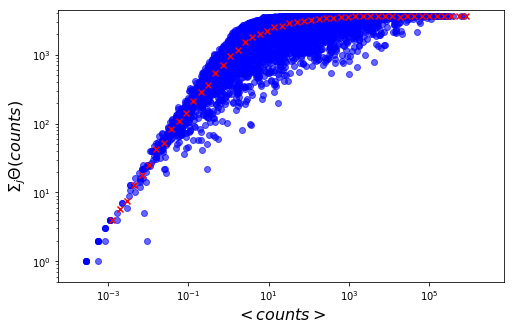

In [19]:
fig=plt.figure(figsize=(8,5))
plt.scatter(means, occurrences, c='b', alpha=0.6, label='data')
bin_means, bin_edges, _ = stats.binned_statistic(means, occurrences, statistic='mean', bins=np.logspace(-3,6))
x = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(x,bin_means, marker='x', c='r')
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.ylabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim(5e-1,nfiles+800)
plt.show()
fig.savefig("diffMean_loglog.png")

### Distributions

In [20]:
from scipy import stats as st

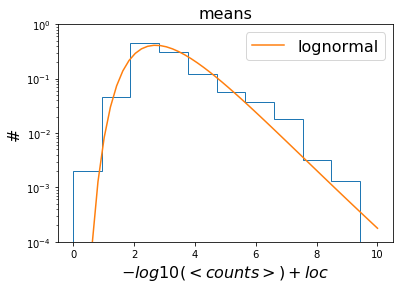

In [21]:
fig = plt.figure()
data = -np.log10(means[means.nonzero()])
data -= data.min()
mu = np.median(data)
s = np.std(data)
fit_params = st.lognorm.fit(data)
n, c, _ = plt.hist(data, density = True, histtype='step')
plt.plot(np.linspace(0,10),st.lognorm.pdf(np.linspace(0,10),*fit_params), label='lognormal')
plt.title("means", fontsize=16)
plt.xlabel("$-log10(<%s>)+loc$"%normalisation_str, fontsize=16)
plt.ylabel("#", fontsize=16)
plt.yscale('log')
plt.ylim(1e-4,1)
plt.legend(fontsize=16)
plt.show()
fig.savefig("mean_distr.pdf")

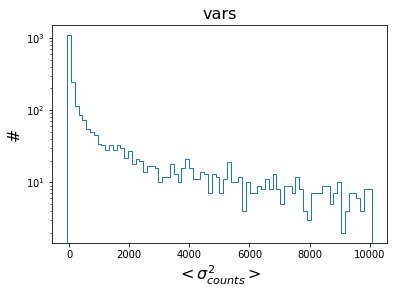

In [22]:
bins = 80
_range = (0-1e4*0.5/bins, 1e4+1e4*0.5/bins)
fig = plt.figure()
n, c, _ = plt.hist(variances, density = False, histtype='step', bins=bins, range=_range)
plt.title("vars", fontsize=16)
plt.xlabel("$<\sigma_{%s}^2>$"%normalisation_str, fontsize=16)
plt.ylabel("#", fontsize=16)
plt.yscale('log')
plt.show()
fig.savefig("var_distr.pdf")

# null

In [24]:
df_null = pd.read_csv(("%s/nullTable.csv"%working_dir), header=None, index_col=[0])
df_null.head()

,1,2,3,4,5,6,7,8,9,10,...,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634
0,,,,,,,,,,,,,,,,,,,,,
NaN,492,1060,940,920,688,496,933,695,459,641,...,631,537,781,822,1057,339,355,867,1022,652
NaN,414,948,764,899,598,475,771,602,419,567,...,570,445,740,744,909,292,343,832,903,701
NaN,2548,5109,4423,4601,3441,2637,4361,3370,2241,3156,...,3111,2472,3993,3949,5127,1655,1756,4414,5120,3560
NaN,64,152,122,136,104,65,118,97,61,99,...,90,80,109,134,142,54,40,133,166,117
NaN,17842,38042,32963,34280,24450,19000,31588,24735,16450,22623,...,22358,18107,28990,29591,37656,12301,13303,31415,37128,25476


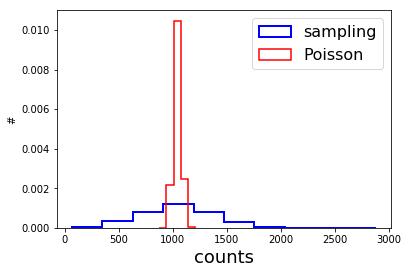

(1040.905888827738, 117500.39510566293)
(1040.9147333669605, 1040.4910122876179)


In [25]:
import scipy.stats as st
fig = plt.figure()
data = df_null.values[37,:]
#data = data/np.average(data)
#data = 2 * np.sqrt(data - 3/8.)
mu = np.average(data)
var = np.var(data)
p = (var - mu) / var
r = mu ** 2 / (var - mu)
n = r / p
c, bin_centers, _ = plt.hist(data, histtype='step', density=True, lw=2, label='sampling', bins=10, color='blue')
#plt.errorbar((bin_centers[1:]+bin_centers[:-1])/2, c, yerr = np.sqrt(c), fmt='none', c='b')
#random = np.random.normal(loc=mu, scale=var, size=5000000)
#random = st.nbinom.rvs(n,p, size=100)
random = np.random.poisson(lam=mu, size=np.sum(data))
plt.hist(random, density=True, histtype='step', lw=1.5, label='Poisson', bins=5, color='red')
plt.xlabel("%s"%normalisation_str, fontsize=18)
plt.ylabel("#")
plt.legend(fontsize=16)
plt.show()
fig.savefig("samplingCrossTissue.png")
print(mu, var)
print(np.average(random),np.var(random))

## meanVariances

In [26]:
df_mv_null = pd.read_csv("meanVariances_null.csv", usecols=[1,2])
df_mv_null.head()

,mean,variance
0,788.580,67988.60
1,716.922,55782.30
2,3922.010,1659170.00
3,112.471,1479.43
4,28493.500,87306300.00


In [27]:
df_occ_null = pd.read_csv("O_null.dat", header=None)
df_mv_null.insert(2,'occurrence', np.array(df_occ_null.values,dtype=float))
#df_mv_null.to_csv("meanVariances_null.csv", index=False, header=True)
df_mv_null.head()

,mean,variance,occurrence
0,788.580,67988.60,1.0
1,716.922,55782.30,1.0
2,3922.010,1659170.00,1.0
3,112.471,1479.43,1.0
4,28493.500,87306300.00,1.0


In [28]:
means_null = np.round(df_mv_null['mean'].values,1)
variances_null = np.round(df_mv_null['variance'].values,1)
occurrences_null = np.round(np.array(df_mv_null['occurrence'].values, dtype=float)*nfiles,1)
len(df_mv_null)

19369

In [29]:
x = means
y = variances
x_lin = np.logspace(np.log10(x[x.nonzero()].min()),np.log10(x[x.nonzero()].max()), dtype=float,num=50)

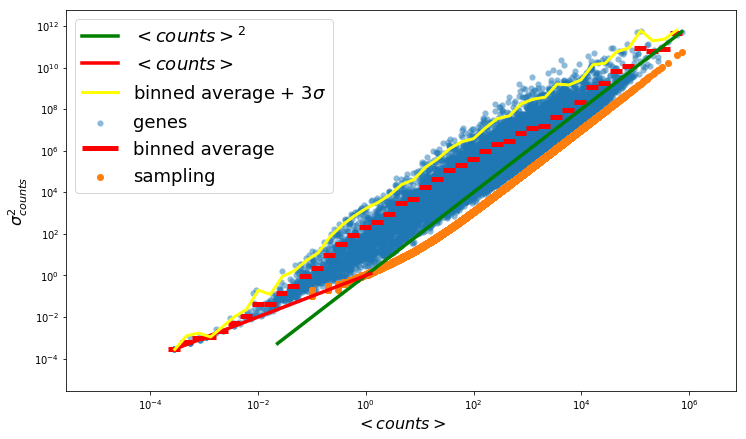

In [30]:
fig=plt.figure(figsize=(12,7))

plt.scatter(x, y, label = 'genes', marker='o', alpha=0.5, linewidths=0.1)

log_bins_for_x = np.logspace(-5, np.log10(np.max(x)), num=50)
bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')

plt.plot(x_lin[-40:],np.power(x_lin[-40:],2), 'g-', lw=3.5, label='$<%s>^2$'%normalisation_str)
plt.plot(x_lin[:20],x_lin[:20], 'r-', lw=3.5, label='$<%s>$'%normalisation_str)



#popt, pcov = curve_fit(lambda x,a,b : a*np.power(x,b), bin_centres, bin_means, bounds=([1,1],[35,5]))
#plt.plot(bin_centres, popt[0]*np.power(bin_centres, popt[1]), color='y', lw=3, label='fit')
#print(popt[0],popt[1])

bin_sigmas,  bin_sigmas_edges, binsigmanumber = stats.binned_statistic(x, y, statistic=np.std, bins=log_bins_for_x)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2, bin_means+bin_sigmas*3, lw=3, color='yellow', label='binned average + $3\sigma$')


plt.scatter(means_null, variances_null, label='sampling')

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)
plt.legend(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(x[x.nonzero()].min()/100,np.power(10,np.log10(x.max())+1))
plt.ylim((y[y.nonzero()].min()/100,np.power(10,np.log10(y.max())+1)))
plt.show()
fig.savefig("varmean_3sigma.png")

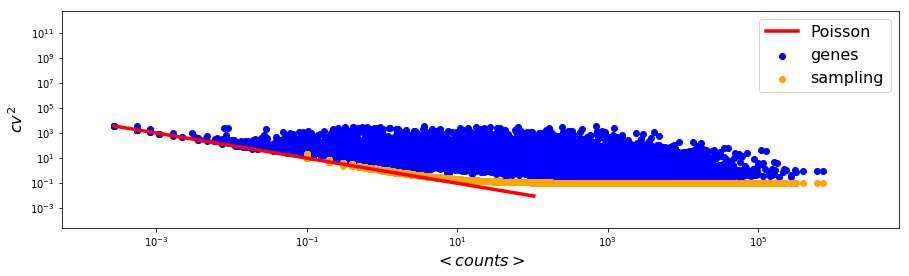

In [31]:
cv2 = [variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0]
cv2_null = [variances_null[i]/(np.power(mean,2)) for i,mean in enumerate(means_null) if mean>0]
fig=plt.figure(figsize=(15,4))
plt.scatter(means[means.nonzero()], cv2, c='b', label ='genes')
plt.scatter(means_null[means_null.nonzero()], cv2_null, c='orange', label='sampling')
plt.plot(x_lin[:30],1./x_lin[:30], 'r-', lw=3.5, label='Poisson')

plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim((variances[variances.nonzero()].min()/10,np.power(10,np.log10(variances.max())+1)))
plt.legend(fontsize=16)
plt.show()
fig.savefig("cvmean_loglog.png")

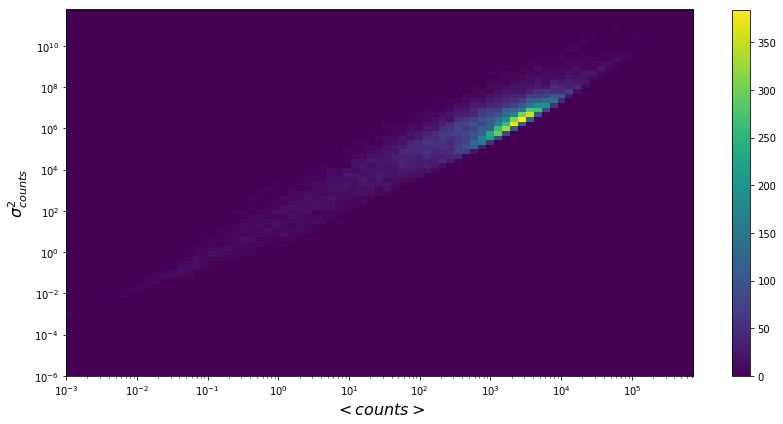

In [32]:
x = means
y = variances

# INIT FIGURE #################################################################

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()


# AX #########################################################################

xmin = np.log10(1e-3)
xmax = np.log10(x.max())
ymin = np.log10(1e-6)
ymax = np.log10(y.max())

nbins=80

xbins = np.logspace(xmin, xmax, nbins) # <- make a range from 10**xmin to 10**xmax
ybins = np.logspace(ymin, ymax, nbins) # <- make a range from 10**ymin to 10**ymax
counts, _, _, _ = ax.hist2d(x, y, bins=(xbins, ybins));

pcm = ax.pcolormesh(xbins, ybins, counts.T)
plt.colorbar(pcm)
#fig.colorbar(pcm, ax=ax)  # this works too


ax.set_xscale("log")               # <- Activate log scale on X axis
ax.set_yscale("log")               # <- Activate log scale on Y axis

ax.set_xlim(xmin=xbins[0])
ax.set_xlim(xmax=xbins[-1])
ax.set_ylim(ymin=ybins[0])
ax.set_ylim(ymax=ybins[-1])

ax.set_title("")
ax.set_xlabel("$<%s>$"%normalisation_str, fontsize=16)
ax.set_ylabel("$\sigma^2_{%s}$"%normalisation_str, fontsize=16)

# SHOW AND SAVE FILE ##########################################################

plt.tight_layout()
plt.show()
fig.savefig("varmean_density.png")

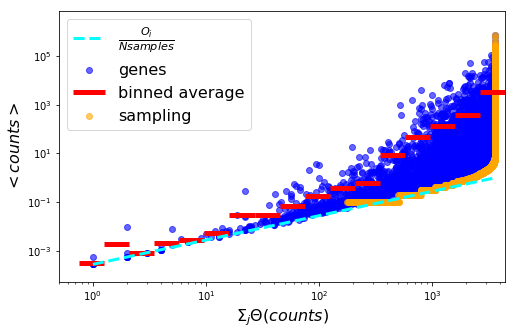

In [33]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences, means, c='b', alpha=0.6, label='genes')

log_bins_for_x = np.logspace(-5, np.log10(np.max(x)), num=50)
bin_means, bin_edges, binnumber = stats.binned_statistic(occurrences, means, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')

plt.scatter(occurrences_null, means_null, c='orange', alpha=0.6, label='sampling')

plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles), lw=3, label='$\\frac{O_i}{Nsamples}$', c='cyan', ls='--')
plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.legend(fontsize=16, loc='upper left')
plt.show()
fig.savefig("meanDiff_binned_sampling.png")

# P_i

In [45]:
#query_g = df_mv[df_mv['mean']>1e-4].index.values
query_g = df_mv.index.values

In [46]:
len(query_g)

19369

In [47]:
N = df.loc[query_g,:].sum(axis=0)

In [67]:
df_null.index=df.index
N_null = df_null.loc[query_g,:].sum(axis=0)

In [48]:
df_p = df.loc[query_g,:].div(N.values, axis=1)

In [68]:
df_p_null = df_null.loc[query_g,:].div(N_null.values, axis=1)

In [69]:
means = df_p.apply(np.average, axis=1).values
variances = df_p.apply(np.var, axis=1).values
o = df_p.apply(lambda x: float(len(np.nonzero(x)[0]))/len(x),axis=1).values

In [ ]:
means_null = df_p_null.apply(np.average, axis=1).values
variances_null = df_p_null.apply(np.var, axis=1).values
o_null = df_p_null.apply(lambda x: float(len(np.nonzero(x)[0]))/len(x),axis=1).values

In [74]:
x = means
y = variances
log_bins_for_x = np.logspace(np.log10(x[x.nonzero()].min()),np.log10(x[x.nonzero()].max()), dtype=float,num=30)

In [75]:
x_null = means_null
y_null = variances_null
log_bins_for_x_null = np.logspace(np.log10(x_null[x_null.nonzero()].min()),np.log10(x_null[x_null.nonzero()].max()), dtype=float,num=30)

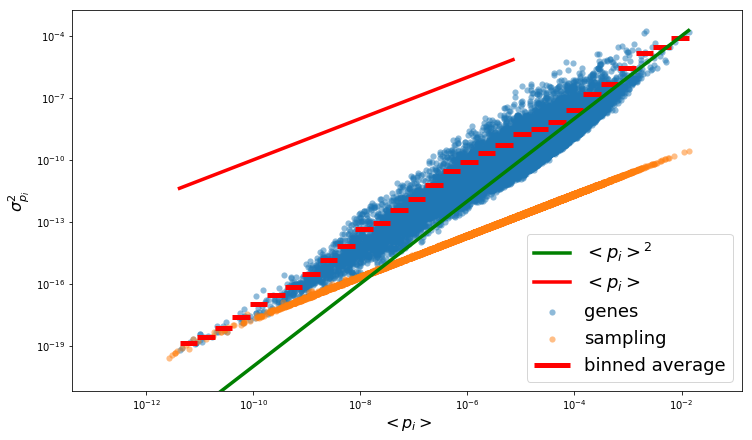

In [77]:
fig=plt.figure(figsize=(12,7))

plt.scatter(x, y, label = 'genes', marker='o', alpha=0.5, linewidths=0.1)
plt.scatter(x_null, y_null, label = 'sampling', marker='o', alpha=0.5, linewidths=0.1)

bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=log_bins_for_x)
bin_centres = (bin_edges[:-1]+bin_edges[1:])/2
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')

plt.plot(log_bins_for_x[-40:],np.power(log_bins_for_x[-40:],2), 'g-', lw=3.5, label='$<p_i>^2$')
plt.plot(log_bins_for_x[:20],log_bins_for_x[:20], 'r-', lw=3.5, label='$<p_i>$')

plt.xlabel("$<p_i>$", fontsize=16)
plt.ylabel("$\sigma^2_{p_i}$", fontsize=16)
plt.legend(fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(x[x.nonzero()].min()/100,np.power(10,np.log10(x.max())+1))
plt.ylim((y[y.nonzero()].min()/100,np.power(10,np.log10(y.max())+1)))
plt.show()
fig.savefig("varmean_pi_3sigma.png")

In [78]:
b = variances/means
pred_o = 1 - 1./nfiles*np.nansum(np.power((1+N.values.reshape(3634,1)*b.reshape(1,len(query_g))),-means*means/variances),axis=0)

/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.
/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


In [79]:
b_null = variances_null/means_null
pred_o_null = 1 - 1./nfiles*np.nansum(np.power((1+N_null.values.reshape(3634,1)*b_null.reshape(1,len(query_g))),-means_null*means_null/variances_null),axis=0)

/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.
/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/Users/filippo/anaconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


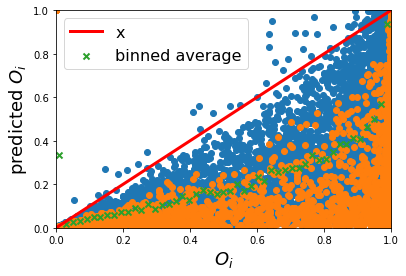

In [81]:
fig = plt.figure()
plt.scatter(o, pred_o)
plt.scatter(o_null, pred_o)
x = np.linspace(0,1)
bin_avg, bin_edges, _ = stats.binned_statistic(o, pred_o, statistic='mean', bins=x)
plt.scatter((bin_edges[1:]+bin_edges[:-1])/2,bin_avg, marker='x', lw=2, label='binned average')
plt.plot(x,x,label='x', lw=3,c='red')
plt.xlabel('$O_i$',fontsize=18)
plt.ylabel('predicted $O_i$',fontsize=18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(fontsize=16)
plt.show()
fig.savefig("o_predictedO.png")

In [54]:
frak_k = []
for sample in df.columns[:100]:
    A = df.loc[:,sample].values
    frak_k.append(np.array([[k,float(len(A[A>=k]))/len(A)] for k in np.logspace(0,np.log10(A.max()),60)]))

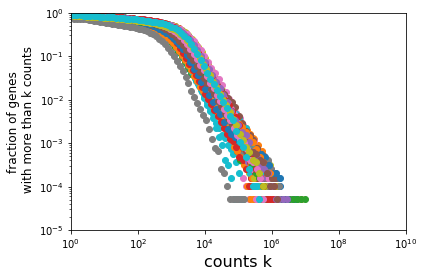

In [55]:
for dataset in frak_k:
    plt.scatter(dataset.T[0],dataset.T[1], linewidths=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('counts k', fontsize=16)
plt.ylabel('fraction of genes\n with more than k counts', fontsize=12)
plt.xlim(1,1e10)
plt.ylim(1e-5,1e0)
plt.show()

# overexpressed

In [ ]:
bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=log_bins_for_x)
bin_sigmas,  bin_sigmas_edges, binsigmanumber = stats.binned_statistic(x, y, statistic=np.std, bins=log_bins_for_x)

def get_mean_sigma(mean, sigma):
    bin_i = 0
    for i,_ in enumerate(bin_edges[:-1]):
        if mean<bin_edges[i+1] and mean > bin_edges[i]:
            bin_i = i
            break
    #print(bin_edges[bin_i],bin_edges[bin_i+1])
    return(mean, sigma, bin_means[bin_i], bin_sigmas[bin_i], sigma>(bin_means[bin_i]+3*bin_sigmas[bin_i]))

In [ ]:
over = []
for g in df_mv.index:
    subdf = df_mv.loc[g,:]
    mean = subdf['mean']
    sigma = subdf['variance']
    r = get_mean_sigma(mean,sigma)
    if r[4]:
        over.append(g)

In [ ]:
len(over)

In [ ]:
for g in over:
    print(g)

## over mean

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
o_min = 3e1
o_max = nfiles
m_min = 5e4
m_max = 1e6

In [ ]:
fig=plt.figure(figsize=(8,5))
plt.scatter(occurrences, means, c='b', alpha=0.6, label='data')
plt.plot(np.linspace(1,nfiles), np.linspace(1,nfiles)/(nfiles*10), lw=2, label='', c='r')

width = o_max - o_min
height = m_max-m_min
plt.gca().add_patch(Rectangle((o_min,m_min), width=width, height=height, fill=False))

plt.ylabel("$<%s>$"%normalisation_str, fontsize=16)
#plt.xlabel("$\Sigma_j\Theta(FPKM-0.1)\Theta(1e5-FPKM)$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(%s)$"%normalisation_str, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+800)
plt.show()
plt.savefig("highmean.png")

In [ ]:
up = []
for g in df_mv.index:
    subdf = df_mv.loc[g,:]
    mean = subdf['mean']
    occ = subdf['occurrence']
    if mean>m_min and mean < m_max and occ*nfiles > o_min and occ*nfiles< o_max:
        up.append(g)

In [ ]:
len(up)

In [ ]:
for g in up:
    print(g)

In [ ]:
dat = df.loc['ENSG00000042832'].values
np.var(dat)/(np.average(dat)**2)

In [ ]:
df_mv[df_mv['mean']>0].sort_values(by='variance', axis=0, ascending=False)

## set by occurrence

In [ ]:
with open("o1.txt",'a') as f:
    for g in df_mv[df_mv['occurrence']>4990].index:
        f.write("%s\n"%g)

## data size Heaps check

In [ ]:
col = df.loc[:,df.keys()[1]].values
np.sum(col)

In [ ]:
len(col[col.nonzero()])

In [ ]:
x = []
y = []
for i in range(1, nfiles):
    col = df.loc[:,df.keys()[i]].values
    x.append(np.sum(col))
    y.append(len(col.nonzero()[0]))
plt.scatter(x,y)

In [ ]:
i=794
x=[]
y=[]
col = df.loc[:,df.keys()[i]].values
x.append(np.sum(col))
y.append(len(col.nonzero()[0]))

In [ ]:
x

In [ ]:
y

In [ ]:
col[8142:8150]